# Machine Learning Benchmark

In [674]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


## Data Processing

In [35]:
data = pd.read_csv('/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/data/econ_predictors.csv', index_col = 0, parse_dates=True)
data = data['2003': '2021']
time_range = data.index

SP = yf.download('SPY', start='2003-01-01', end='2021-10-01')['Adj Close']
IEF = yf.download('IEF', start='2003-01-01', end='2021-10-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
# market data
SP_ret = SP.diff().dropna()
SP_ret = SP_ret.resample('M').mean()
date = [date.replace(day=1) for date in SP_ret.index]
SP_ret.index = date

IEF_ret = IEF.diff().dropna()
IEF_ret = IEF_ret.resample('M').mean()
date = [date.replace(day=1) for date in IEF_ret.index]
IEF_ret.index = date

ret_array = np.vstack((SP_ret, IEF_ret)).T

In [63]:
# standardize feature set
scaler = StandardScaler()
scaler.fit(data)
X = scaler.transform(data)

In [153]:
# add label
thredshould = 0
label = [SP_ret > thredshould] * 1
label = np.asarray([label[0][1:]* 1])


In [155]:
# combine X and y
data = np.concatenate((X[:len(X) - 1], label.T), axis=1)

In [558]:
# rolling window subset
window_size = 5 * 12
year_start = 0
year_end = len(data)
year_range = np.arange(year_start, year_end)
training_idx_list = np.array([np.arange(year, year + window_size, 1) for year in year_range[:-window_size]])
testing_idx_list = np.array([training_idx_list[:,window_size-1] + 1]).T

## Training and prediction

In [560]:
X_train, y_train = data[training_idx_list, 0:12], data[training_idx_list, 12]
X_test, y_test = data[testing_idx_list, 0:12], data[testing_idx_list, 12]

In [519]:
def get_ml_predict_prob(X_train, y_train, X_test, seed, model):
    np.random.seed(seed)
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[0][1]

    return prob


In [535]:
def get_ml_predict_prob_avg(X_train, y_train, X_test, model):
    seed_range = np.arange(0, 30)
    
    # loop for different seed and get average prob
    ml_prob_list = [get_ml_predict_prob(X_train, y_train, X_test, seed, model) for seed in seed_range]
    ml_prob_avg = np.mean(ml_prob_list)
    return ml_prob_avg

In [472]:
clf = svm.SVC(probability = True)
neigh = KNeighborsClassifier(n_neighbors=3)

In [578]:
svm_prob_list = [get_ml_predict_prob_avg(X_train, y_train, X_test, model = clf) for X_train, y_train, X_test in zip(X_train, y_train, X_test)]
knn_prob_list = [get_ml_predict_prob_avg(X_train, y_train, X_test, model = neigh) for X_train, y_train, X_test in zip(X_train, y_train, X_test)]
naive_prob_list = [0.5] * len(svm_prob_list)

## Backtesting

In [608]:
# ml portfolio
svm_weights_matrix = np.vstack((np.array(svm_prob_list), 1 - np.array(svm_prob_list)))
knn_weights_matrix = np.vstack((np.array(knn_prob_list), 1 - np.array(knn_prob_list)))
naive_weights_matrix = np.vstack((np.array(naive_prob_list), 1 - np.array(naive_prob_list)))

# market data
ret_test = ret_array[(window_size + 1):(window_size + len(X_test) + 1)]
#price_test = 

In [632]:
svm_portfolio_ret = [weight @ ret for weight, ret in zip(svm_weights_matrix.T,ret_test)]
knn_portfolio_ret = [weight @ ret for weight, ret in zip(knn_weights_matrix.T,ret_test)]
naive_portfolio_ret = [weight @ ret for weight, ret in zip(naive_weights_matrix.T,ret_test)]

In [635]:
portfolio_ret_df = pd.DataFrame({'svm': svm_portfolio_ret, 'knn':knn_portfolio_ret, 'naive': naive_portfolio_ret})

In [687]:
index = SP_ret.index[(window_size + 1):(window_size + len(X_test) + 1)]

In [688]:
portfolio_ret_df.index = index

In [659]:
portfolio_ret_df.add(1).cumprod().sub(1)

,svm,knn,naive
0,-0.066696,0.040698,-0.046625
1,-0.045149,0.086970,-0.046955
2,-0.064365,0.006488,0.021087
3,-0.057306,-0.005533,0.031208
4,-0.302597,-0.274696,-0.169037
...,...,...,...
159,-23.656106,-20.473272,178.692355
160,-31.808103,-28.703442,221.400685
161,-44.747431,-42.354673,288.269633
162,-63.906503,-66.646103,370.197114


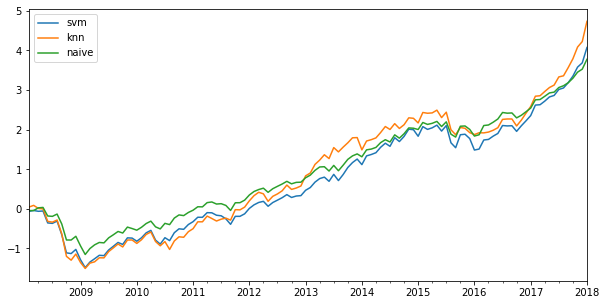

In [689]:
fig = np.log(portfolio_ret_df[0:120] + 1).cumsum().plot(figsize = (10,5))

In [690]:
fig.get_figure().savefig("/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/picture/ml_cum.png")